# Quantifiers

The quantifiers are parameters calculated for each simulation that allows us to evaluate the characteristics of the colonie. The main characteristic are the four-cell organisation and the elongation of the colony.

The chosen quantifiers are :
- the aspect ration $\alpha_r$
- the density $\delta$
- the distance $d_2$

## Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

## Data loading and cleaning

In [18]:
def convert(L):
    T = L.split(" ")
    T.pop()
    return list(np.array(T,dtype=float))

df = pd.read_csv("simu7.txt",sep="\t")

df["X"]=df["X"].apply(convert)
# df

## Calculating the aspect ratio

The aspect ratio refers to the elongation of the shape of the colony.
To calculate $\alpha_r$, we need to calculate the convex hull of the points of the colony and fit an ellipse on it. $\alpha_r$ is then defined as the ratio $\frac{l}{L}$ with $l$ the semi-minor axis and $L$ the semi-major axis.


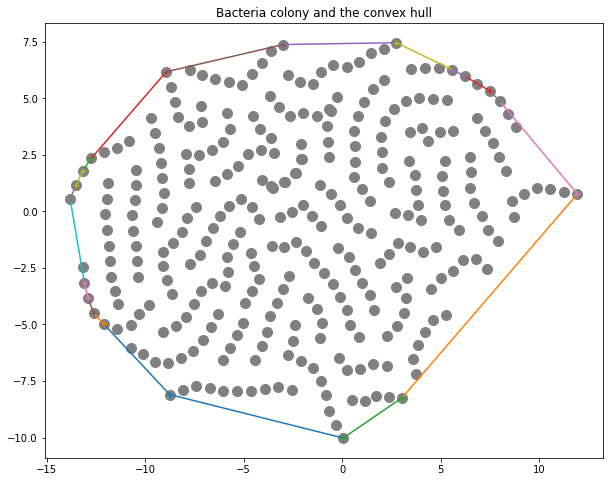

In [19]:
# Merge all the X datas
X = []
dfX = df["X"]
for i in range(dfX.shape[0]):
    X = X + dfX[i]

# Separates x and y
x=X[0::2]
y=X[1::2]

# Converting the points to a compatible format for the Convexhull class
points = np.array([x,y])
points = np.transpose(points)

# Calculating the hull
hull = ConvexHull(points)

# Calculating the vertices of the hull
x1 =[]
y1 =[]
for i in hull.vertices:
    x1.append(x[i])
    y1.append(y[i])

plt.figure(figsize=(10,8))
plt.plot(points[:,0],points[:,1],".",color="grey",markersize=20)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], '+-',)
plt.title("Bacteria colony and the convex hull")
plt.show()

a, b, c, d, e, f = [-4.16403615e-01 -2.49166634e-03 -9.09176452e-01 -9.16001976e-01
 -1.68889014e+00  6.60138363e+01]
x0, y0, ap, bp, e, phi =  -1.097122389140729 -0.9272988052600225 12.71305436174365 8.603608999926555 0.7362093259679376 3.1390644652252293


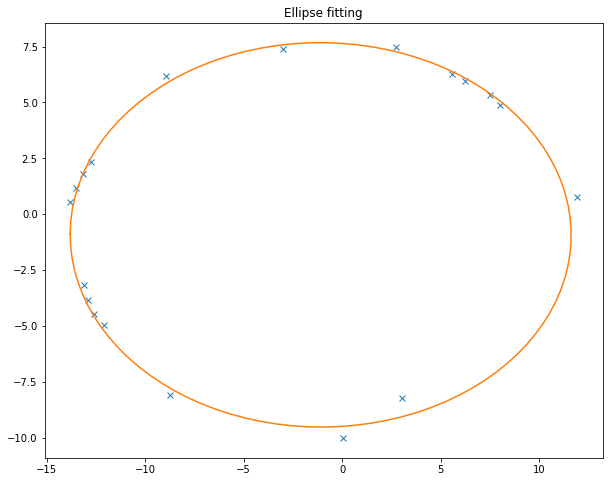

The aspect ratio is :  0.6767538905376421


In [20]:
# reference : https://scipython.com/blog/direct-linear-least-squares-fitting-of-an-ellipse/

def fit_ellipse(x, y):
    """

    Fit the coefficients a,b,c,d,e,f, representing an ellipse described by
    the formula F(x,y) = ax^2 + bxy + cy^2 + dx + ey + f = 0 to the provided
    arrays of data points x=[x1, x2, ..., xn] and y=[y1, y2, ..., yn].

    Based on the algorithm of Halir and Flusser, "Numerically stable direct
    least squares fitting of ellipses'.


    """

    D1 = np.vstack([x**2, x*y, y**2]).T
    D2 = np.vstack([x, y, np.ones(len(x))]).T
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    T = -np.linalg.inv(S3) @ S2.T
    M = S1 + S2 @ T
    C = np.array(((0, 0, 2), (0, -1, 0), (2, 0, 0)), dtype=float)
    M = np.linalg.inv(C) @ M
    eigval, eigvec = np.linalg.eig(M)
    con = 4 * eigvec[0]* eigvec[2] - eigvec[1]**2
    ak = eigvec[:, np.nonzero(con > 0)[0]]
    return np.concatenate((ak, T @ ak)).ravel()

def cart_to_pol(coeffs):
    """

    Convert the cartesian conic coefficients, (a, b, c, d, e, f), to the
    ellipse parameters, where F(x, y) = ax^2 + bxy + cy^2 + dx + ey + f = 0.
    The returned parameters are x0, y0, ap, bp, e, phi, where (x0, y0) is the
    ellipse centre; (ap, bp) are the semi-major and semi-minor axes,
    respectively; e is the eccentricity; and phi is the rotation of the semi-
    major axis from the x-axis.

    """

    # We use the formulas from https://mathworld.wolfram.com/Ellipse.html
    # which assumes a cartesian form ax^2 + 2bxy + cy^2 + 2dx + 2fy + g = 0.
    # Therefore, rename and scale b, d and f appropriately.
    a = coeffs[0]
    b = coeffs[1] / 2
    c = coeffs[2]
    d = coeffs[3] / 2
    f = coeffs[4] / 2
    g = coeffs[5]

    den = b**2 - a*c
    if den > 0:
        raise ValueError('coeffs do not represent an ellipse: b^2 - 4ac must'
                         ' be negative!')

    # The location of the ellipse centre.
    x0, y0 = (c*d - b*f) / den, (a*f - b*d) / den

    num = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    fac = np.sqrt((a - c)**2 + 4*b**2)
    # The semi-major and semi-minor axis lengths (these are not sorted).
    ap = np.sqrt(num / den / (fac - a - c))
    bp = np.sqrt(num / den / (-fac - a - c))

    # Sort the semi-major and semi-minor axis lengths but keep track of
    # the original relative magnitudes of width and height.
    width_gt_height = True
    if ap < bp:
        width_gt_height = False
        ap, bp = bp, ap

    # The eccentricity.
    r = (bp/ap)**2
    if r > 1:
        r = 1/r
    e = np.sqrt(1 - r)

    # The angle of anticlockwise rotation of the major-axis from x-axis.
    if b == 0:
        phi = 0 if a < c else np.pi/2
    else:
        phi = np.arctan((2.*b) / (a - c)) / 2
        if a > c:
            phi += np.pi/2
    if not width_gt_height:
        # Ensure that phi is the angle to rotate to the semi-major axis.
        phi += np.pi/2
    phi = phi % np.pi

    return x0, y0, ap, bp, e, phi

def get_ellipse_pts(params, npts=100, tmin=0, tmax=2*np.pi):
    """
    Return npts points on the ellipse described by the params = x0, y0, ap,
    bp, e, phi for values of the parametric variable t between tmin and tmax.

    """

    x0, y0, ap, bp, e, phi = params
    # A grid of the parametric variable, t.
    t = np.linspace(tmin, tmax, npts)
    x = x0 + ap * np.cos(t) * np.cos(phi) - bp * np.sin(t) * np.sin(phi)
    y = y0 + ap * np.cos(t) * np.sin(phi) + bp * np.sin(t) * np.cos(phi)
    return x, y

x = np.array(x1)
y = np.array(y1)

# Calculating the Cartesian coefficients
coeffs = fit_ellipse(x, y)
print('a, b, c, d, e, f =', coeffs)

# Converting the coefficient into ellipse parameters
x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)
print('x0, y0, ap, bp, e, phi = ', x0, y0, ap, bp, e, phi)

plt.figure(figsize=(10,8))
plt.plot(x, y, 'x')     # given points
x, y = get_ellipse_pts((x0, y0, ap, bp, e, phi))    # Ellipse
plt.plot(x, y)
plt.title("Ellipse fitting")
plt.show()

print("The aspect ratio is : ",bp/ap)